# Solving a Fourth Order Elliptic Singular Perturbation Problem

$$
\left\{\begin{array}{lr}
\varepsilon^{2} \Delta^{2} u-\Delta u=f & \text { in } \Omega \\
u=\partial_{n} u=0 & \text { on } \partial \Omega
\end{array}\right.
$$

## Problem 3
Now let's move to the next stage:
$$
\begin{aligned}
\left(\nabla w_{h}, \nabla \chi_{h}\right)&=\left(f, \chi_{h}\right) \\
\left(\operatorname{curl}_{h} z_{h}, \operatorname{curl}_{h} v_{h}\right) &=\left(\nabla w_{h}, \nabla_{h} v_{h}\right) \\
\left(\phi_{h}, \psi_{h}\right)+\varepsilon^{2}\left(\nabla_{h} \phi_{h}, \nabla_{h} \psi_{h}\right)+\left(\operatorname{div}_{h} \psi_{h}, p_{h}\right) &=\left(\operatorname{curl}_{h} z_{h}, \psi_{h}\right) \\
\left(\operatorname{div}_{h} \phi_{h}, q_{h}\right) &=0 \\
\left(\operatorname{curl}_{h} u_{h 0}, \operatorname{curl}_{h} \chi_{h}\right) &=\left(\phi_{h}, \operatorname{curl}_{h} \chi_{h}\right)
\end{aligned}
$$

In [106]:
from skfem import *
import numpy as np
from utils import solver_iter_krylov, solver_iter_pyamg, solver_iter_mgcg
from skfem.helpers import d, dd, ddd, dot, ddot, grad, dddot, prod, div, curl
from scipy.sparse.linalg import LinearOperator, minres
from skfem.models.poisson import *
from skfem.assembly import BilinearForm, LinearForm
from skfem.visuals.matplotlib import draw, plot
import scipy.sparse.linalg as spl
from scipy.sparse import bmat
from skfem.visuals.matplotlib import draw, plot
import datetime
import pandas as pd
import sys
import time

pi = np.pi
sin = np.sin
cos = np.cos
exp = np.exp

# parameters

tol = 1e-5
intorder = 4
solver_type = 'mgcg'
refine_time = 5
epsilon_range = 4
zero_ep = False
element_type = 'P1'
sigma = 5
penalty = True
example = 'ex1'

## Forms and errors

In [107]:
def easy_boundary(basis):
    '''
    Input basis
    ----------------
    Return D for boundary conditions
    '''

    dofs = basis.find_dofs({
        'left': m.facets_satisfying(lambda x: x[0] == 0),
        'right': m.facets_satisfying(lambda x: x[0] == 1),
        'top': m.facets_satisfying(lambda x: x[1] == 1),
        'buttom': m.facets_satisfying(lambda x: x[1] == 0)
    })

    D = np.concatenate((dofs['left'].nodal['u'], dofs['right'].nodal['u'],
                        dofs['top'].nodal['u'], dofs['buttom'].nodal['u'],
                        dofs['left'].facet['u_n'], dofs['right'].facet['u_n'],
                        dofs['top'].facet['u_n'], dofs['buttom'].facet['u_n']))
    return D


@BilinearForm
def laplace(u, v, w):
    '''
    for $(\nabla w_{h}, \nabla \chi_{h})$
    '''
    return dot(grad(u), grad(v))


@Functional
def L2uError(w):
    x, y = w.x
    return (w.w - exact_u(x, y))**2


def get_DuError(basis, u):
    duh = basis.interpolate(u).grad
    x = basis.global_coordinates().value
    dx = basis.dx  # quadrature weights
    dux, duy = dexact_u(x[0], x[1])
    return np.sqrt(np.sum(((duh[0] - dux)**2 + (duh[1] - duy)**2) * dx))


def get_D2uError(basis, u):
    dduh = basis.interpolate(u).hess
    x = basis.global_coordinates(
    ).value  # coordinates of quadrature points [x, y]
    dx = basis.dx  # quadrature weights
    duxx, duxy, duyx, duyy = ddexact(x[0], x[1])
    return np.sqrt(
        np.sum(((dduh[0][0] - duxx)**2 + (dduh[0][1] - duxy)**2 +
                (dduh[1][1] - duyy)**2 + (dduh[1][0] - duyx)**2) * dx))

## Examples

In [108]:
if example == 'ex1':

    @LinearForm
    def f_load(v, w):
        '''
        for $(f, x_{h})$
        '''
        pix = pi * w.x[0]
        piy = pi * w.x[1]
        lu = 2 * (pi)**2 * (cos(2 * pix) * ((sin(piy))**2) + cos(2 * piy) *
                            ((sin(pix))**2))
        llu = -8 * (pi)**4 * (cos(2 * pix) * sin(piy)**2 + cos(2 * piy) *
                            sin(pix)**2 - cos(2 * pix) * cos(2 * piy))
        return (epsilon**2 * llu - lu) * v


    def exact_u(x, y):
        return (sin(pi * x) * sin(pi * y))**2


    def dexact_u(x, y):
        dux = 2 * pi * cos(pi * x) * sin(pi * x) * sin(pi * y)**2
        duy = 2 * pi * cos(pi * y) * sin(pi * x)**2 * sin(pi * y)
        return dux, duy


    def ddexact(x, y):
        duxx = 2 * pi**2 * cos(pi * x)**2 * sin(pi * y)**2 - 2 * pi**2 * sin(
            pi * x)**2 * sin(pi * y)**2
        duxy = 2 * pi * cos(pi * x) * sin(pi * x) * 2 * pi * cos(pi * y) * sin(
            pi * y)
        duyx = duxy
        duyy = 2 * pi**2 * cos(pi * y)**2 * sin(pi * x)**2 - 2 * pi**2 * sin(
            pi * y)**2 * sin(pi * x)**2
        return duxx, duxy, duyx, duyy

elif example == 'ex2':

    @LinearForm
    def f_load(v, w):
        '''
        for $(f, x_{h})$
        '''
        x = w.x[0]
        y = w.x[1]
        return (
            (sin(pi * x) / 2 - (ep * pi * (exp(-x / ep) + exp(
                (x - 1) / ep) - exp(-1 / ep) - 1)) / (2 * (exp(-1 / ep) - 1))) *
            (12 * y + ep *
            ((exp(-y / ep) *
            (3 / (exp(-1 / ep) - 1) + 1 /
                (exp(-1 / ep) + 2 * ep * (exp(-1 / ep) - 1) + 1))) / ep**2 + (exp(
                    (y - 1) / ep) * (3 / (exp(-1 / ep) - 1) - 1 /
                                    (exp(-1 / ep) + 2 * ep *
                                    (exp(-1 / ep) - 1) + 1))) / ep**2)) -
            ((pi**2 * sin(pi * x)) / 2 + (ep * pi * (exp(-x / ep) / ep**2 + exp(
                (x - 1) / ep) / ep**2)) / (2 * (exp(-1 / ep) - 1))) *
            (ep * (exp((y - 1) / ep) * (3 / (exp(-1 / ep) - 1) - 1 /
                                        (exp(-1 / ep) + 2 * ep *
                                        (exp(-1 / ep) - 1) + 1)) + exp(-y / ep) *
                (3 / (exp(-1 / ep) - 1) + 1 /
                    (exp(-1 / ep) + 2 * ep *
                    (exp(-1 / ep) - 1) + 1)) - (3 * exp(-1 / ep) + 3) /
                (exp(-1 / ep) - 1) - ((2 * y - 1) * (exp(-1 / ep) - 1)) /
                (exp(-1 / ep) + 2 * ep * (exp(-1 / ep) - 1) + 1)) + 2 * y *
            (y**2 - 1)) - ep**2 *
            (((pi**4 * sin(pi * x)) / 2 - (ep * pi * (exp(-x / ep) / ep**4 + exp(
                (x - 1) / ep) / ep**4)) / (2 * (exp(-1 / ep) - 1))) *
            (ep * (exp((y - 1) / ep) * (3 / (exp(-1 / ep) - 1) - 1 /
                                        (exp(-1 / ep) + 2 * ep *
                                        (exp(-1 / ep) - 1) + 1)) + exp(-y / ep) *
                    (3 / (exp(-1 / ep) - 1) + 1 /
                    (exp(-1 / ep) + 2 * ep *
                    (exp(-1 / ep) - 1) + 1)) - (3 * exp(-1 / ep) + 3) /
                    (exp(-1 / ep) - 1) - ((2 * y - 1) * (exp(-1 / ep) - 1)) /
                    (exp(-1 / ep) + 2 * ep * (exp(-1 / ep) - 1) + 1)) + 2 * y *
            (y**2 - 1)) - 2 *
            (12 * y + ep *
            ((exp(-y / ep) *
                (3 / (exp(-1 / ep) - 1) + 1 /
                (exp(-1 / ep) + 2 * ep * (exp(-1 / ep) - 1) + 1))) / ep**2 + (exp(
                    (y - 1) / ep) * (3 / (exp(-1 / ep) - 1) - 1 /
                                    (exp(-1 / ep) + 2 * ep *
                                    (exp(-1 / ep) - 1) + 1))) / ep**2)) *
            ((pi**2 * sin(pi * x)) / 2 + (ep * pi * (exp(-x / ep) / ep**2 + exp(
                (x - 1) / ep) / ep**2)) / (2 * (exp(-1 / ep) - 1))) + ep *
            (sin(pi * x) / 2 - (ep * pi * (exp(-x / ep) + exp(
                (x - 1) / ep) - exp(-1 / ep) - 1)) / (2 * (exp(-1 / ep) - 1))) *
            ((exp(-y / ep) *
            (3 / (exp(-1 / ep) - 1) + 1 /
                (exp(-1 / ep) + 2 * ep * (exp(-1 / ep) - 1) + 1))) / ep**4 + (exp(
                    (y - 1) / ep) * (3 / (exp(-1 / ep) - 1) - 1 /
                                    (exp(-1 / ep) + 2 * ep *
                                    (exp(-1 / ep) - 1) + 1))) / ep**4))) * v


    def exact_u(x, y):
        return -(sin(pi * x) / 2 - (ep * pi * (exp(-x / ep) + exp(
            (x - 1) / ep) - exp(-1 / ep) - 1)) /
                (2 *
                (exp(-1 / ep) - 1))) * (ep * (exp(
                    (y - 1) / ep) * (3 / (exp(-1 / ep) - 1) - 1 /
                                    (exp(-1 / ep) + 2 * ep *
                                        (exp(-1 / ep) - 1) + 1)) + exp(-y / ep) *
                                                (3 / (exp(-1 / ep) - 1) + 1 /
                                                (exp(-1 / ep) + 2 * ep *
                                                (exp(-1 / ep) - 1) + 1)) -
                                                (3 * exp(-1 / ep) + 3) /
                                                (exp(-1 / ep) - 1) -
                                                ((2 * y - 1) *
                                                (exp(-1 / ep) - 1)) /
                                                (exp(-1 / ep) + 2 * ep *
                                                (exp(-1 / ep) - 1) + 1)) + 2 * y *
                                        (y**2 - 1))


    def dexact_u(x, y):
        dux = -((pi * cos(pi * x)) / 2 + (ep * pi * (exp(-x / ep) / ep - exp(
            (x - 1) / ep) / ep)) /
                (2 *
                (exp(-1 / ep) - 1))) * (ep * (exp(
                    (y - 1) / ep) * (3 / (exp(-1 / ep) - 1) - 1 /
                                    (exp(-1 / ep) + 2 * ep *
                                    (exp(-1 / ep) - 1) + 1)) + exp(-y / ep) *
                                            (3 / (exp(-1 / ep) - 1) + 1 /
                                                (exp(-1 / ep) + 2 * ep *
                                                (exp(-1 / ep) - 1) + 1)) -
                                            (3 * exp(-1 / ep) + 3) /
                                            (exp(-1 / ep) - 1) -
                                            ((2 * y - 1) * (exp(-1 / ep) - 1)) /
                                            (exp(-1 / ep) + 2 * ep *
                                                (exp(-1 / ep) - 1) + 1)) + 2 * y *
                                        (y**2 - 1))
        duy = (sin(pi * x) / 2 - (ep * pi * (exp(-x / ep) + exp(
            (x - 1) / ep) - exp(-1 / ep) - 1)) /
            (2 * (exp(-1 / ep) - 1))) * (ep * (
                (2 * (exp(-1 / ep) - 1)) / (exp(-1 / ep) + 2 * ep *
                                            (exp(-1 / ep) - 1) + 1) +
                (exp(-y / ep) * (3 / (exp(-1 / ep) - 1) + 1 /
                                    (exp(-1 / ep) + 2 * ep *
                                    (exp(-1 / ep) - 1) + 1))) / ep -
                (exp((y - 1) / ep) *
                    (3 / (exp(-1 / ep) - 1) - 1 /
                    (exp(-1 / ep) + 2 * ep *
                    (exp(-1 / ep) - 1) + 1))) / ep) - 6 * y**2 + 2)
        return dux, duy


    def ddexact(x, y):
        duxx = ((pi**2 * sin(pi * x)) / 2 + (ep * pi * (exp(-x / ep) / ep**2 + exp(
            (x - 1) / ep) / ep**2)) /
                (2 *
                (exp(-1 / ep) - 1))) * (ep * (exp(
                    (y - 1) / ep) * (3 / (exp(-1 / ep) - 1) - 1 /
                                    (exp(-1 / ep) + 2 * ep *
                                    (exp(-1 / ep) - 1) + 1)) + exp(-y / ep) *
                                            (3 / (exp(-1 / ep) - 1) + 1 /
                                                (exp(-1 / ep) + 2 * ep *
                                                (exp(-1 / ep) - 1) + 1)) -
                                            (3 * exp(-1 / ep) + 3) /
                                            (exp(-1 / ep) - 1) -
                                            ((2 * y - 1) * (exp(-1 / ep) - 1)) /
                                            (exp(-1 / ep) + 2 * ep *
                                                (exp(-1 / ep) - 1) + 1)) + 2 * y *
                                        (y**2 - 1))
        duxy = ((pi * cos(pi * x)) / 2 + (ep * pi * (exp(-x / ep) / ep - exp(
            (x - 1) / ep) / ep)) / (2 * (exp(-1 / ep) - 1))) * (ep * (
                (2 * (exp(-1 / ep) - 1)) / (exp(-1 / ep) + 2 * ep *
                                            (exp(-1 / ep) - 1) + 1) +
                (exp(-y / ep) * (3 / (exp(-1 / ep) - 1) + 1 /
                                (exp(-1 / ep) + 2 * ep *
                                (exp(-1 / ep) - 1) + 1))) / ep -
                (exp((y - 1) / ep) *
                (3 / (exp(-1 / ep) - 1) - 1 /
                (exp(-1 / ep) + 2 * ep *
                (exp(-1 / ep) - 1) + 1))) / ep) - 6 * y**2 + 2)
        duyx = duxy
        duyy = -(sin(pi * x) / 2 - (ep * pi * (exp(-x / ep) + exp(
            (x - 1) / ep) - exp(-1 / ep) - 1)) /
                (2 *
                (exp(-1 / ep) - 1))) * (12 * y + ep *
                                        ((exp(-y / ep) *
                                            (3 / (exp(-1 / ep) - 1) + 1 /
                                            (exp(-1 / ep) + 2 * ep *
                                            (exp(-1 / ep) - 1) + 1))) / ep**2 +
                                        (exp((y - 1) / ep) *
                                            (3 / (exp(-1 / ep) - 1) - 1 /
                                            (exp(-1 / ep) + 2 * ep *
                                            (exp(-1 / ep) - 1) + 1))) / ep**2))
        return duxx, duxy, duyx, duyy

elif example == 'ex3':

    @LinearForm
    def f_load(v, w):
        pix = pi * w.x[0]
        piy = pi * w.x[1]
        return (2 * pi**2 * sin(pix) * sin(piy)) * v


    def exact_u(x, y):
        return sin(pi * x) * sin(pi * y)


    def dexact_u(x, y):
        dux = pi * cos(pi * x) * sin(pi * y)
        duy = pi * cos(pi * y) * sin(pi * x)
        return dux, duy


    def ddexact(x, y):
        duxx = -pi**2 * sin(pi * x) * sin(pi * y)
        duxy = pi * cos(pi * x) * pi * cos(pi * y)
        duyx = duxy
        duyy = -pi**2 * sin(pi * y) * sin(pi * x)
        return duxx, duxy, duyx, duyy

else:
    raise Exception('Example not supported')

## Solving

In [109]:
epsilon = 1
ep = epsilon

### Equation 1
$$
\left(\nabla w_{h}, \nabla \chi_{h}\right)=\left(f, \chi_{h}\right)
$$

In [110]:
m = MeshTri()
m.refine(2)
element1 = ElementTriP1()

basis1 = InteriorBasis(m, element1, intorder=intorder)

K1 = asm(laplace, basis1)
f1 = asm(f_load, basis1)

wh = solve(*condense(K1, f1, D=basis1.find_dofs()), solver=solver_iter_krylov(Precondition=True, tol=tol))

In [111]:
wh

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , 49.82355409,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , 15.31526385,  0.        ,  0.        ,
       15.31526385,  0.        ,  0.        ,  0.        ,  8.03875957,
       23.35402342, 23.35402342, 23.35402342, 23.35402342,  8.03875957])

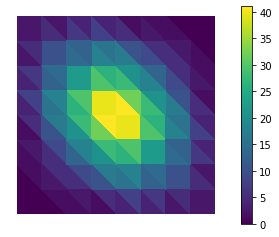

In [112]:
plot(basis1, wh, colorbar=True)

### Equation 2
$$
\left(\operatorname{curl}_{h} z_{h}, \operatorname{curl}_{h} v_{h}\right)=\left(\nabla w_{h}, \nabla_{h} v_{h}\right)
$$

In [113]:
@BilinearForm
def zv_load(u, v, w):
    '''
    for 5.7a
    '''
    global uuu, vvv
    uuu = u
    vvv = v
    return dot(curl(u), curl(v))

In [114]:
element2 = ElementTriMorley()
basis2 = InteriorBasis(m, element2, intorder=intorder)

K2 = asm(zv_load, basis2)
f2 = asm(laplace, basis1, basis2) * wh

zh = solve(*condense(K2, f2, D=basis2.find_dofs()), solver=solver_iter_krylov(Precondition=True, tol=tol))
# zh = solve(*condense(K2, f2, D=easy_boundary(basis2)), solver=solver_iter_krylov(Precondition=True, tol=tol))

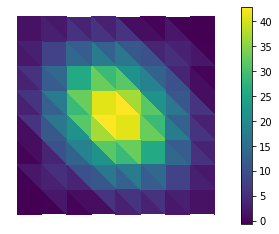

In [115]:
plot(basis2, zh, colorbar=True)

### Equation 3
$$
\begin{aligned}
\left(\phi_{h}, \psi_{h}\right)+\varepsilon^{2}c_{h}\left(\phi_{h}, \psi_{h}\right)+\left(\operatorname{div}_{h} \psi_{h}, p_{h}\right) &=\left(\operatorname{curl}_{h} z_{h}, \psi_{h}\right) \\
\left(\operatorname{div}_{h} \phi_{h}, q_{h}\right)&=0
\end{aligned}
$$
where 
$$
c_{h}\left(\phi_{h}, \psi_{h}\right):=\left(\nabla_{h} \phi_{h}, \nabla_{h} \psi_{h}\right)-\sum_{F \in \mathcal{F}_{h}^{0}}\left(\partial_{n}\left(\phi_{h} \cdot t\right), \psi_{h} \cdot t\right)_{F}-\sum_{F \in \mathcal{F}_{h}^{O}}\left(\phi_{h} \cdot t, \partial_{n}\left(\psi_{h} \cdot t\right)\right)_{F}+\sum_{F \in \mathcal{F}_{h}^{\partial}} \frac{\sigma}{h_{F}}\left(\phi_{h} \cdot t, \psi_{h} \cdot t\right)_{F}
$$

In [116]:
class ElementTriP1CR(ElementH1):
    
    facet_dofs = 1
    dim = 2
    maxdeg = 1
    dofnames = ['u']
    doflocs = np.array([[.5, 0.], [.5, .5], [0., .5]])
    mesh_type = MeshTri

    def lbasis(self, X, i):
        x, y = X

        if i == 0:
            phi = 1. - 2. * y
            dphi = np.array([0. * x, -2. + 0. * y])
        elif i == 1:
            phi = 2. * x + 2. * y - 1.
            dphi = np.array([2. + 0. * x, 2. + 0. * y])
        elif i == 2:
            phi = 1. - 2. * x
            dphi = np.array([-2. + 0. * x, 0. * x])
        else:
            self._index_error()
        return phi, dphi

In [117]:
@BilinearForm
def phipsi_load1(u, v, w):
    '''
    for 5.7b $(phi, psi)$
    '''
    return dot(u, v)

@BilinearForm
def phipsi_load2(u, v, w):
    '''
    for 5.7b $(Laplace_phi, Laplace_psi)$
    '''
    return ddot(grad(u), grad(v))

@BilinearForm
def phipsi_load3(u, v, w):
    '''
    for 5.7b $(div_phi, p)$
    '''
    return div(u) * v

@BilinearForm
def zpsi_load(u, v, w):
    '''
    for 5.7b $(curl_z, psi)$
    '''
    return dot(curl(u), v)

@BilinearForm
def phiq_load(u, v, w):
    '''
    for 5.7c $(div_phi, q)$
    '''
    return div(u) * v

@BilinearForm
def mass(u, v, w):
    '''
    for 5.7c C
    '''
    return u * v * 1e-6

In [118]:
element3 = {'phi': ElementVectorH1(ElementTriP1CR()), 'p': ElementTriP0()}
basis3 = {variable: InteriorBasis(m, e, intorder=intorder) for variable, e in element3.items()}  

In [119]:
fbasis = FacetBasis(m, element3['phi'], intorder=intorder)

In [120]:
@BilinearForm
def penalty_1(u, v, w):
    global uuu, vvv, www
    uuu = u
    vvv = v
    www = w
    w_t = np.array([-w.n[1], w.n[0]])
    return ((dot(d(u)[0], w.n)*w_t[0]) + (dot(d(u)[1], w.n)*w_t[1])) * dot(v, w_t)


@BilinearForm
def penalty_2(u, v, w):
    w_t = np.array([-w.n[1], w.n[0]])
    return ((dot(d(v)[0], w.n)*w_t[0]) + (dot(d(v)[1], w.n)*w_t[1])) * dot(u, w_t)


@BilinearForm
def penalty_3(u, v, w):
    w_t = np.array([-w.n[1], w.n[0]])
    return (sigma / w.h) * dot(u, w_t) * dot(v, w_t)

In [121]:
# p1 = asm(penalty_1, fbasis)

# w_t = np.array([-www.n[1], www.n[0]])

# www.x.shape

# uuu.value.shape

# ((dot(d(uuu)[0], www.n)*w_t[0]) + (dot(d(uuu)[1], www.n)*w_t[1])).shape

In [122]:
p1 = asm(penalty_1, fbasis)
p2 = asm(penalty_2, fbasis)
p3 = asm(penalty_3, fbasis)
P = p1 + p2 + p3

In [123]:
# aaaaa = p1.todense()

# np.sum(aaaaa != 0)

In [124]:
A = asm(phipsi_load1, basis3['phi']) + epsilon**2 * asm(phipsi_load2, basis3['phi']) + epsilon**2 * P
B = asm(phiq_load, basis3['phi'], basis3['p'])
C = asm(mass, basis3['p'])

In [125]:
F1 = asm(zpsi_load, basis2, basis3['phi']) * zh
f3 = np.concatenate([F1, np.zeros(B.shape[0])])
K3 = bmat([[A, -B.T], [-B, C * 0]], 'csr')

# phip = solve(*condense(K3, f3, D=basis3['phi'].find_dofs()), solver=solver_iter_krylov(Precondition=True, tol=1e-5))
phip = solve(*condense(K3, f3, D=basis3['phi'].find_dofs()), solver=solver_iter_krylov(spl.minres, tol=1e-13))
phih, ph = np.split(phip, [A.shape[0]])

In [126]:
# uuu.value.shape

# uuu.value.shape

# vvv.value.shape

# dot(uuu, vvv).shape

# (uuu.value * vvv.value).shape

# phih

# phih.shape

# phih[::2]

# aaaa = np.array([0, 1, 0, 1])
# aaaa

# import copy

# aaaa_copy = copy.copy(aaaa)

# aaaa_copy

# aaaa[1::2] = aaaa_copy[::2]
# aaaa

# aaaa_copy

# a = [1]
# b = a
# a = -b[0]
# b

# aaaa[::2] = -aaaa_copy[1::2]
# aaaa

# aaaa

# aaaa_copy[1::2]

# phih_copy = copy.copy(phih)

# phih[1::2] = phih_copy[::2]

# phih[::2] = -phih_copy[1::2]

In [127]:
testbasis = InteriorBasis(m, ElementTriP1CR(), intorder=intorder)

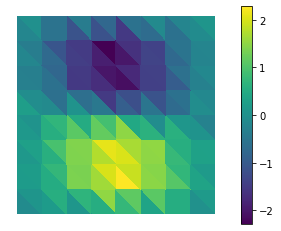

In [128]:
plot(testbasis, phih[::2], colorbar=True)

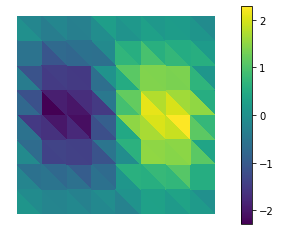

In [129]:
plot(testbasis, phih[1::2], colorbar=True)

### Exact $\phi$

In [130]:
exact_phi = dexact_u(testbasis.doflocs[0], testbasis.doflocs[1])

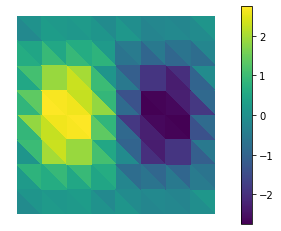

In [131]:
plot(testbasis, exact_phi[0], colorbar=True)

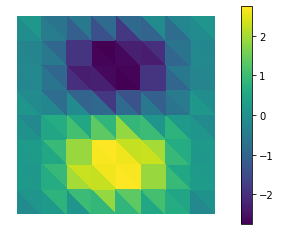

In [132]:
plot(testbasis, exact_phi[1], colorbar=True)

### Equation 4
$$
\left(\operatorname{curl}_{h} u_{h 0}, \operatorname{curl}_{h} \chi_{h}\right)=\left(\phi_{h}, \operatorname{curl}_{h} \chi_{h}\right)
$$

In [133]:
@BilinearForm
def phichi_load(u, v, w):
    '''
    for 5.7d $(phi, curl_chi)$
    '''
    global uuu, vvv
    uuu = u
    vvv = v
    return dot(u, curl(v))

@BilinearForm
def uchi_load(u, v, w):
    '''
    for 5.7d $(curl_u, curl_chi)$
    '''
    return dot(curl(u), curl(v))

In [134]:
element4 = ElementTriMorley()
basis4 = InteriorBasis(m, element4, intorder=intorder)

K4 = asm(uchi_load, basis4)
f4 = asm(phichi_load, basis3['phi'], basis4) * phih

uh = solve(*condense(K4, f4, D=basis4.find_dofs()), solver=solver_iter_krylov(Precondition=True, tol=tol))
# uh = solve(*condense(K4, f4, D=easy_boundary(basis4)), solver=solver_iter_krylov(Precondition=True, tol=tol))

In [135]:
u = exact_u(basis4.doflocs[0], basis4.doflocs[1])

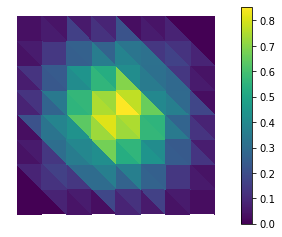

In [136]:
plot(basis4, u, colorbar=True)

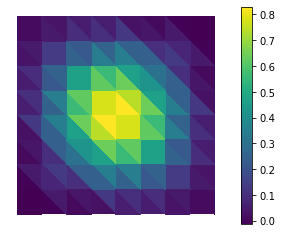

In [137]:
plot(basis4, uh, colorbar=True)

### Error Estimation

In [138]:
U = basis2.interpolate(uh).value

L2u = np.sqrt(L2uError.assemble(basis2, w=U))

L2u

0.047611006244617796

# Error Estimating

## Solver

In [139]:
def solve_problem3(m, element_type='P1', solver_type='pcg', tol=1e-8):
    '''
    solver for decoupled problem1
    without modifying solver
    only for testing convergence
    '''
    
    # equation 1
    
    if element_type == 'P1':
        element1 = ElementTriP1()
    elif element_type == 'P2':
        element1 = ElementTriP2()
    else:
        raise Exception("Element not supported")
        
    basis1 = InteriorBasis(m, element1, intorder=intorder)

    K1 = asm(laplace, basis1)
    f1 = asm(f_load, basis1)

    wh = solve(*condense(K1, f1, D=basis1.find_dofs()), solver=solver_iter_krylov(Precondition=True, tol=tol))
    
    # equation 2
    
    element2 = ElementTriMorley()
    basis2 = InteriorBasis(m, element2, intorder=intorder)

    K2 = asm(zv_load, basis2)
    f2 = asm(laplace, basis1, basis2) * wh

    zh = solve(*condense(K2, f2, D=easy_boundary(basis2)), solver=solver_iter_krylov(Precondition=True, tol=tol))

    # equation 3
    
    element3 = {'phi': ElementVectorH1(ElementTriP1CR()), 'p': ElementTriP0()}
    basis3 = {variable: InteriorBasis(m, e, intorder=intorder) for variable, e in element3.items()}  

    A = asm(phipsi_load1, basis3['phi']) + epsilon**2 * asm(phipsi_load2, basis3['phi'])
    B = asm(phiq_load, basis3['phi'], basis3['p'])
    C = asm(mass, basis3['p'])
    F1 = asm(zpsi_load, basis2, basis3['phi']) * zh

    f3 = np.concatenate([F1, np.zeros(B.shape[0])])
    K3 = bmat([[A, -B.T], [-B, C * 0]], 'csr')

    phip = solve(*condense(K3, f3, D=basis3['phi'].find_dofs()), solver=solver_iter_krylov(spl.minres, tol=1e-13))
    phih, ph = np.split(phip, [A.shape[0]])

    # equation 4
    
    element4 = ElementTriMorley()
    basis4 = InteriorBasis(m, element4, intorder=intorder)

    K4 = asm(uchi_load, basis4)
    f4 = asm(phichi_load, basis3['phi'], basis4) * phih
    
    uh0 = solve(*condense(K4, f4, D=easy_boundary(basis4)), solver=solver_iter_krylov(Precondition=True, tol=tol))
    
    
#     basis = {
#         variable: InteriorBasis(m, e, intorder=intorder)
#         for variable, e in element.items()
#     }  # intorder: integration order for quadrature

#     K1 = asm(laplace, basis['w'])
#     f1 = asm(f_load, basis['w'])

#     if solver_type == 'amg':
#         wh = solve(*condense(K1, f1, D=basis['w'].find_dofs()), solver=solver_iter_pyamg(tol=tol))
#     elif solver_type == 'pcg':
#         wh = solve(*condense(K1, f1, D=basis['w'].find_dofs()), solver=solver_iter_krylov(Precondition=True, tol=tol))
#     elif solver_type == 'mgcg':
#         wh = solve(*condense(K1, f1, D=basis['w'].find_dofs()), solver=solver_iter_mgcg(tol=tol))
#     else:
#         raise Exception("Solver not supported")

#     K2 = epsilon**2 * asm(a_load, basis['u']) + asm(b_load, basis['u'])
#     f2 = asm(wv_load, basis['w'], basis['u']) * wh

#     if solver_type == 'amg':
#         uh0 = solve(*condense(K2, f2, D=easy_boundary(basis['u'])), solver=solver_iter_pyamg(tol=tol))
#     elif solver_type == 'pcg':
#         uh0 = solve(*condense(K2, f2, D=easy_boundary(basis['u'])), solver=solver_iter_krylov(Precondition=True, tol=tol))
#     elif solver_type == 'mgcg':
#         uh0 = solve(*condense(K2, f2, D=easy_boundary(basis['u'])), solver=solver_iter_mgcg(tol=tol))
#     else:
#         raise Exception("Solver not supported")

    return uh0, {'u' :basis4}

In [140]:
def solve_problem4(m, element_type='P1', solver_type='pcg', tol=1e-8):
    '''
    solver for decoupled problem2
    without modifying solver
    only for testing convergence
    '''
    
    # equation 1
    
    if element_type == 'P1':
        element1 = ElementTriP1()
    elif element_type == 'P2':
        element1 = ElementTriP2()
    else:
        raise Exception("Element not supported")
        
    basis1 = InteriorBasis(m, element1, intorder=intorder)

    K1 = asm(laplace, basis1)
    f1 = asm(f_load, basis1)

    wh = solve(*condense(K1, f1, D=basis1.find_dofs()), solver=solver_iter_krylov(Precondition=True, tol=tol))
    
    # equation 2
    
    element2 = ElementTriMorley()
    basis2 = InteriorBasis(m, element2, intorder=intorder)

    K2 = asm(zv_load, basis2)
    f2 = asm(laplace, basis1, basis2) * wh

    zh = solve(*condense(K2, f2, D=basis2.find_dofs()), solver=solver_iter_krylov(Precondition=True, tol=tol))

    # equation 3
    
    element3 = {'phi': ElementVectorH1(ElementTriP1CR()), 'p': ElementTriP0()}
    basis3 = {variable: InteriorBasis(m, e, intorder=intorder) for variable, e in element3.items()}  
    
    fbasis = FacetBasis(m, element3['phi'], intorder=intorder)
    
    p1 = asm(penalty_1, fbasis)
    p2 = asm(penalty_2, fbasis)
    p3 = asm(penalty_3, fbasis)
    P = p1 + p2 + p3
    
    A = asm(phipsi_load1, basis3['phi']) + epsilon**2 * asm(phipsi_load2, basis3['phi']) + epsilon**2 * P
    B = asm(phiq_load, basis3['phi'], basis3['p'])
    C = asm(mass, basis3['p'])

    A = asm(phipsi_load1, basis3['phi']) + epsilon**2 * asm(phipsi_load2, basis3['phi'])
    B = asm(phiq_load, basis3['phi'], basis3['p'])
    C = asm(mass, basis3['p'])
    F1 = asm(zpsi_load, basis2, basis3['phi']) * zh

    f3 = np.concatenate([F1, np.zeros(B.shape[0])])
    K3 = bmat([[A, -B.T], [-B, C * 0]], 'csr')

    phip = solve(*condense(K3, f3, D=basis3['phi'].find_dofs()), solver=solver_iter_krylov(spl.minres, tol=1e-13))
    phih, ph = np.split(phip, [A.shape[0]])

    # equation 4
    
    element4 = ElementTriMorley()
    basis4 = InteriorBasis(m, element4, intorder=intorder)

    K4 = asm(uchi_load, basis4)
    f4 = asm(phichi_load, basis3['phi'], basis4) * phih
    
    uh0 = solve(*condense(K4, f4, D=basis4.find_dofs()), solver=solver_iter_krylov(Precondition=True, tol=tol))

    return uh0, {'u' :basis4}

## Testing convergence

In [141]:
tol = 1e-8
intorder = 5
solver_type = 'mgcg'
refine_time = 6
epsilon_range = 5
zero_ep = False
element_type = 'P1'
sigma = 5
penalty = True
example = 'ex1'

In [142]:
if example == 'ex1':

    @LinearForm
    def f_load(v, w):
        '''
        for $(f, x_{h})$
        '''
        pix = pi * w.x[0]
        piy = pi * w.x[1]
        lu = 2 * (pi)**2 * (cos(2 * pix) * ((sin(piy))**2) + cos(2 * piy) *
                            ((sin(pix))**2))
        llu = -8 * (pi)**4 * (cos(2 * pix) * sin(piy)**2 + cos(2 * piy) *
                            sin(pix)**2 - cos(2 * pix) * cos(2 * piy))
        return (epsilon**2 * llu - lu) * v


    def exact_u(x, y):
        return (sin(pi * x) * sin(pi * y))**2


    def dexact_u(x, y):
        dux = 2 * pi * cos(pi * x) * sin(pi * x) * sin(pi * y)**2
        duy = 2 * pi * cos(pi * y) * sin(pi * x)**2 * sin(pi * y)
        return dux, duy


    def ddexact(x, y):
        duxx = 2 * pi**2 * cos(pi * x)**2 * sin(pi * y)**2 - 2 * pi**2 * sin(
            pi * x)**2 * sin(pi * y)**2
        duxy = 2 * pi * cos(pi * x) * sin(pi * x) * 2 * pi * cos(pi * y) * sin(
            pi * y)
        duyx = duxy
        duyy = 2 * pi**2 * cos(pi * y)**2 * sin(pi * x)**2 - 2 * pi**2 * sin(
            pi * y)**2 * sin(pi * x)**2
        return duxx, duxy, duyx, duyy

elif example == 'ex2':

    @LinearForm
    def f_load(v, w):
        '''
        for $(f, x_{h})$
        '''
        x = w.x[0]
        y = w.x[1]
        return (
            (sin(pi * x) / 2 - (ep * pi * (exp(-x / ep) + exp(
                (x - 1) / ep) - exp(-1 / ep) - 1)) / (2 * (exp(-1 / ep) - 1))) *
            (12 * y + ep *
            ((exp(-y / ep) *
            (3 / (exp(-1 / ep) - 1) + 1 /
                (exp(-1 / ep) + 2 * ep * (exp(-1 / ep) - 1) + 1))) / ep**2 + (exp(
                    (y - 1) / ep) * (3 / (exp(-1 / ep) - 1) - 1 /
                                    (exp(-1 / ep) + 2 * ep *
                                    (exp(-1 / ep) - 1) + 1))) / ep**2)) -
            ((pi**2 * sin(pi * x)) / 2 + (ep * pi * (exp(-x / ep) / ep**2 + exp(
                (x - 1) / ep) / ep**2)) / (2 * (exp(-1 / ep) - 1))) *
            (ep * (exp((y - 1) / ep) * (3 / (exp(-1 / ep) - 1) - 1 /
                                        (exp(-1 / ep) + 2 * ep *
                                        (exp(-1 / ep) - 1) + 1)) + exp(-y / ep) *
                (3 / (exp(-1 / ep) - 1) + 1 /
                    (exp(-1 / ep) + 2 * ep *
                    (exp(-1 / ep) - 1) + 1)) - (3 * exp(-1 / ep) + 3) /
                (exp(-1 / ep) - 1) - ((2 * y - 1) * (exp(-1 / ep) - 1)) /
                (exp(-1 / ep) + 2 * ep * (exp(-1 / ep) - 1) + 1)) + 2 * y *
            (y**2 - 1)) - ep**2 *
            (((pi**4 * sin(pi * x)) / 2 - (ep * pi * (exp(-x / ep) / ep**4 + exp(
                (x - 1) / ep) / ep**4)) / (2 * (exp(-1 / ep) - 1))) *
            (ep * (exp((y - 1) / ep) * (3 / (exp(-1 / ep) - 1) - 1 /
                                        (exp(-1 / ep) + 2 * ep *
                                        (exp(-1 / ep) - 1) + 1)) + exp(-y / ep) *
                    (3 / (exp(-1 / ep) - 1) + 1 /
                    (exp(-1 / ep) + 2 * ep *
                    (exp(-1 / ep) - 1) + 1)) - (3 * exp(-1 / ep) + 3) /
                    (exp(-1 / ep) - 1) - ((2 * y - 1) * (exp(-1 / ep) - 1)) /
                    (exp(-1 / ep) + 2 * ep * (exp(-1 / ep) - 1) + 1)) + 2 * y *
            (y**2 - 1)) - 2 *
            (12 * y + ep *
            ((exp(-y / ep) *
                (3 / (exp(-1 / ep) - 1) + 1 /
                (exp(-1 / ep) + 2 * ep * (exp(-1 / ep) - 1) + 1))) / ep**2 + (exp(
                    (y - 1) / ep) * (3 / (exp(-1 / ep) - 1) - 1 /
                                    (exp(-1 / ep) + 2 * ep *
                                    (exp(-1 / ep) - 1) + 1))) / ep**2)) *
            ((pi**2 * sin(pi * x)) / 2 + (ep * pi * (exp(-x / ep) / ep**2 + exp(
                (x - 1) / ep) / ep**2)) / (2 * (exp(-1 / ep) - 1))) + ep *
            (sin(pi * x) / 2 - (ep * pi * (exp(-x / ep) + exp(
                (x - 1) / ep) - exp(-1 / ep) - 1)) / (2 * (exp(-1 / ep) - 1))) *
            ((exp(-y / ep) *
            (3 / (exp(-1 / ep) - 1) + 1 /
                (exp(-1 / ep) + 2 * ep * (exp(-1 / ep) - 1) + 1))) / ep**4 + (exp(
                    (y - 1) / ep) * (3 / (exp(-1 / ep) - 1) - 1 /
                                    (exp(-1 / ep) + 2 * ep *
                                    (exp(-1 / ep) - 1) + 1))) / ep**4))) * v


    def exact_u(x, y):
        return -(sin(pi * x) / 2 - (ep * pi * (exp(-x / ep) + exp(
            (x - 1) / ep) - exp(-1 / ep) - 1)) /
                (2 *
                (exp(-1 / ep) - 1))) * (ep * (exp(
                    (y - 1) / ep) * (3 / (exp(-1 / ep) - 1) - 1 /
                                    (exp(-1 / ep) + 2 * ep *
                                        (exp(-1 / ep) - 1) + 1)) + exp(-y / ep) *
                                                (3 / (exp(-1 / ep) - 1) + 1 /
                                                (exp(-1 / ep) + 2 * ep *
                                                (exp(-1 / ep) - 1) + 1)) -
                                                (3 * exp(-1 / ep) + 3) /
                                                (exp(-1 / ep) - 1) -
                                                ((2 * y - 1) *
                                                (exp(-1 / ep) - 1)) /
                                                (exp(-1 / ep) + 2 * ep *
                                                (exp(-1 / ep) - 1) + 1)) + 2 * y *
                                        (y**2 - 1))


    def dexact_u(x, y):
        dux = -((pi * cos(pi * x)) / 2 + (ep * pi * (exp(-x / ep) / ep - exp(
            (x - 1) / ep) / ep)) /
                (2 *
                (exp(-1 / ep) - 1))) * (ep * (exp(
                    (y - 1) / ep) * (3 / (exp(-1 / ep) - 1) - 1 /
                                    (exp(-1 / ep) + 2 * ep *
                                    (exp(-1 / ep) - 1) + 1)) + exp(-y / ep) *
                                            (3 / (exp(-1 / ep) - 1) + 1 /
                                                (exp(-1 / ep) + 2 * ep *
                                                (exp(-1 / ep) - 1) + 1)) -
                                            (3 * exp(-1 / ep) + 3) /
                                            (exp(-1 / ep) - 1) -
                                            ((2 * y - 1) * (exp(-1 / ep) - 1)) /
                                            (exp(-1 / ep) + 2 * ep *
                                                (exp(-1 / ep) - 1) + 1)) + 2 * y *
                                        (y**2 - 1))
        duy = (sin(pi * x) / 2 - (ep * pi * (exp(-x / ep) + exp(
            (x - 1) / ep) - exp(-1 / ep) - 1)) /
            (2 * (exp(-1 / ep) - 1))) * (ep * (
                (2 * (exp(-1 / ep) - 1)) / (exp(-1 / ep) + 2 * ep *
                                            (exp(-1 / ep) - 1) + 1) +
                (exp(-y / ep) * (3 / (exp(-1 / ep) - 1) + 1 /
                                    (exp(-1 / ep) + 2 * ep *
                                    (exp(-1 / ep) - 1) + 1))) / ep -
                (exp((y - 1) / ep) *
                    (3 / (exp(-1 / ep) - 1) - 1 /
                    (exp(-1 / ep) + 2 * ep *
                    (exp(-1 / ep) - 1) + 1))) / ep) - 6 * y**2 + 2)
        return dux, duy


    def ddexact(x, y):
        duxx = ((pi**2 * sin(pi * x)) / 2 + (ep * pi * (exp(-x / ep) / ep**2 + exp(
            (x - 1) / ep) / ep**2)) /
                (2 *
                (exp(-1 / ep) - 1))) * (ep * (exp(
                    (y - 1) / ep) * (3 / (exp(-1 / ep) - 1) - 1 /
                                    (exp(-1 / ep) + 2 * ep *
                                    (exp(-1 / ep) - 1) + 1)) + exp(-y / ep) *
                                            (3 / (exp(-1 / ep) - 1) + 1 /
                                                (exp(-1 / ep) + 2 * ep *
                                                (exp(-1 / ep) - 1) + 1)) -
                                            (3 * exp(-1 / ep) + 3) /
                                            (exp(-1 / ep) - 1) -
                                            ((2 * y - 1) * (exp(-1 / ep) - 1)) /
                                            (exp(-1 / ep) + 2 * ep *
                                                (exp(-1 / ep) - 1) + 1)) + 2 * y *
                                        (y**2 - 1))
        duxy = ((pi * cos(pi * x)) / 2 + (ep * pi * (exp(-x / ep) / ep - exp(
            (x - 1) / ep) / ep)) / (2 * (exp(-1 / ep) - 1))) * (ep * (
                (2 * (exp(-1 / ep) - 1)) / (exp(-1 / ep) + 2 * ep *
                                            (exp(-1 / ep) - 1) + 1) +
                (exp(-y / ep) * (3 / (exp(-1 / ep) - 1) + 1 /
                                (exp(-1 / ep) + 2 * ep *
                                (exp(-1 / ep) - 1) + 1))) / ep -
                (exp((y - 1) / ep) *
                (3 / (exp(-1 / ep) - 1) - 1 /
                (exp(-1 / ep) + 2 * ep *
                (exp(-1 / ep) - 1) + 1))) / ep) - 6 * y**2 + 2)
        duyx = duxy
        duyy = -(sin(pi * x) / 2 - (ep * pi * (exp(-x / ep) + exp(
            (x - 1) / ep) - exp(-1 / ep) - 1)) /
                (2 *
                (exp(-1 / ep) - 1))) * (12 * y + ep *
                                        ((exp(-y / ep) *
                                            (3 / (exp(-1 / ep) - 1) + 1 /
                                            (exp(-1 / ep) + 2 * ep *
                                            (exp(-1 / ep) - 1) + 1))) / ep**2 +
                                        (exp((y - 1) / ep) *
                                            (3 / (exp(-1 / ep) - 1) - 1 /
                                            (exp(-1 / ep) + 2 * ep *
                                            (exp(-1 / ep) - 1) + 1))) / ep**2))
        return duxx, duxy, duyx, duyy

elif example == 'ex3':

    @LinearForm
    def f_load(v, w):
        pix = pi * w.x[0]
        piy = pi * w.x[1]
        return (2 * pi**2 * sin(pix) * sin(piy)) * v


    def exact_u(x, y):
        return sin(pi * x) * sin(pi * y)


    def dexact_u(x, y):
        dux = pi * cos(pi * x) * sin(pi * y)
        duy = pi * cos(pi * y) * sin(pi * x)
        return dux, duy


    def ddexact(x, y):
        duxx = -pi**2 * sin(pi * x) * sin(pi * y)
        duxy = pi * cos(pi * x) * pi * cos(pi * y)
        duyx = duxy
        duyy = -pi**2 * sin(pi * y) * sin(pi * x)
        return duxx, duxy, duyx, duyy

else:
    raise Exception('Example not supported')

In [ ]:
df_list = []
for j in range(epsilon_range):
    epsilon = 1 * 10**(-j*2) * (1 - zero_ep)
    ep = epsilon
    L2_list = []
    Du_list = []
    D2u_list = []
    h_list = []
    epu_list = []
    m = MeshTri()

    for i in range(1, refine_time+1):
        
        m.refine()
        
        uh0, basis = solve_problem4(m, element_type, solver_type, tol=tol)

        U = basis['u'].interpolate(uh0).value

        # compute errors

        L2u = np.sqrt(L2uError.assemble(basis['u'], w=U))
        Du = get_DuError(basis['u'], uh0)
        H1u = Du + L2u
        D2u = get_D2uError(basis['u'], uh0)
        H2u = Du + L2u + D2u
        epu = np.sqrt(epsilon**2 * D2u**2 + Du**2)
        h_list.append(m.param())
        Du_list.append(Du)
        L2_list.append(L2u)
        D2u_list.append(D2u)
        epu_list.append(epu)
        
    hs = np.array(h_list)
    L2s = np.array(L2_list)
    Dus = np.array(Du_list)
    D2us = np.array(D2u_list)
    epus = np.array(epu_list)
    H1s = L2s + Dus
    H2s = H1s + D2us
    
    # store data
    data = np.array([L2s, H1s, H2s, epus])
    df = pd.DataFrame(data.T, columns=['L2', 'H1', 'H2', 'Energy'])
    df_list.append(df)
    
    print('epsilon =', epsilon)
    print('  h    L2u   H1u   H2u   epu')
    for i in range(H2s.shape[0] - 1):
        print(
            '2^-' + str(i + 2), ' {:.2f}  {:.2f}  {:.2f}  {:.2f}'.format(
                -np.log2(L2s[i + 1] / L2s[i]), -np.log2(H1s[i + 1] / H1s[i]),
                -np.log2(H2s[i + 1] / H2s[i]),
                -np.log2(epus[i + 1] / epus[i])))
#         print(
#             '2^-' + str(i + 2), ' {:.5f}  {:.5f}  {:.5f}  {:.5f}'.format(
#                 L2s[i + 1], H1s[i + 1],
#                 H2s[i + 1],
#                 epus[i + 1]))

epsilon = 1
  h    L2u   H1u   H2u   epu
2^-2  1.83  0.87  0.71  0.70
2^-3  2.19  1.76  1.02  0.98
2^-4  2.16  1.93  1.05  1.02
2^-5  2.06  1.98  1.02  1.01
2^-6  2.02  2.00  1.01  1.00
